In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
import igraph
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import scanpy as sc
import os
import re
import pickle
from matplotlib_venn import venn2

I'll be following the scvelo vignette for performing RNA velocity analysis BEYOND creating stream plots. Those are all contained in the velocity_analysis.qmd markdown.

I'm performing this analysis for just the objects that contain cancer cells.

In [2]:
sc_obs = ['mm_mets_cancer_cells', 'patient_mets_cancer_cells', 'mm_prim_cancer_cells', 'patient_prim_cancer_cells', 'dogs_prim_cancer_cells']
sn_obs = ['mm_mets_cancer_cells', 'patient_mets_cancer_cells', 'dogs_mets_cancer_cells', 'patient_prim_cancer_cells']
# os.makedirs("loom_output/split_ad/sc")
# os.makedirs("loom_output/split_ad/sn")
# os.makedirs("figures/scvelo/split_methods/sc")
# os.makedirs("figures/scvelo/split_methods/sn")


# Get Velocity Driving Genes

First, I'm going to get the top 100 genes in terms of "velocity score" within each Ann_Level3.

## Single-Nucleus

In [3]:
sn_velo_genes = dict()
sn_ob_dict = dict()
# get velocity-driving genes
for ob in sn_obs:
    tmp = anndata.read("loom_output/split_ad/sn/" + ob + ".ad")
    sn_ob_dict[ob] = tmp
    scv.tl.rank_velocity_genes(tmp, groupby = "Ann_Level3", min_corr = 0.3)
    rank_genes = tmp.uns["rank_velocity_genes"]
    df = pd.DataFrame(tmp.uns["rank_velocity_genes"]["names"])
    sn_velo_genes[ob] = df


ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:23) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


## Single Cell

In [4]:
sc_velo_genes = dict()
sc_ob_dict = dict()
# get velocity-driving genes
for ob in sc_obs:
    tmp = anndata.read("loom_output/split_ad/sc/" + ob + ".ad")
    sc_ob_dict[ob] = tmp
    scv.tl.rank_velocity_genes(tmp, groupby = "Ann_Level3", min_corr = 0.3)
    rank_genes = tmp.uns["rank_velocity_genes"]
    df = pd.DataFrame(tmp.uns["rank_velocity_genes"]["names"])
    sc_velo_genes[ob] = df

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:04) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:13) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:17) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


# Compare Velocity Driving Genes

Now I'm going to investigate how much overlap there is between velocity driving genes across methods and models within each tumor type

### Tumor Apoptosis

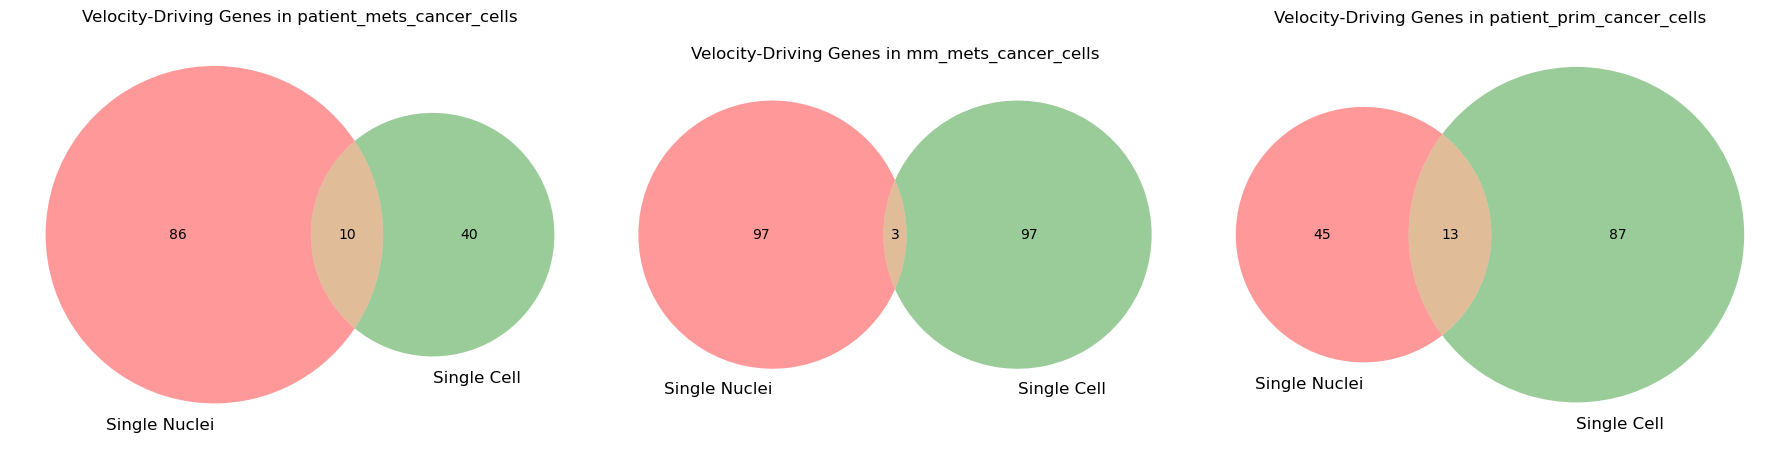

In [174]:
sc_obs = list(sc_velo_genes.keys())
sn_obs = list(sn_velo_genes.keys())

like_keys = set(sc_obs) & set(sn_obs)
like_keys

num_venns = len(like_keys)
# #set subplot layout
# cols = 3
# rows = 1
# fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))

def velo_venn(cell_type):
    #set subplot layout
    cols = 3
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))
    for i, ob in enumerate(like_keys):
        # just get genes from tumor apoptosis; they're all the same across the tumor types
        sn_genes = sn_velo_genes[ob][cell_type]
        sc_genes = sc_velo_genes[ob][cell_type]
        ax = axes[i]
        venn2([set(sn_genes), set(sc_genes)], set_labels = ("Single Nuclei", "Single Cell"), ax = ax)
        ax.set_title(f"Velocity-Driving Genes in {ob}")
    plt.tight_layout()
    plt.show()

velo_venn("Tumor_Apoptosis")


### Tumor Fibrogenic

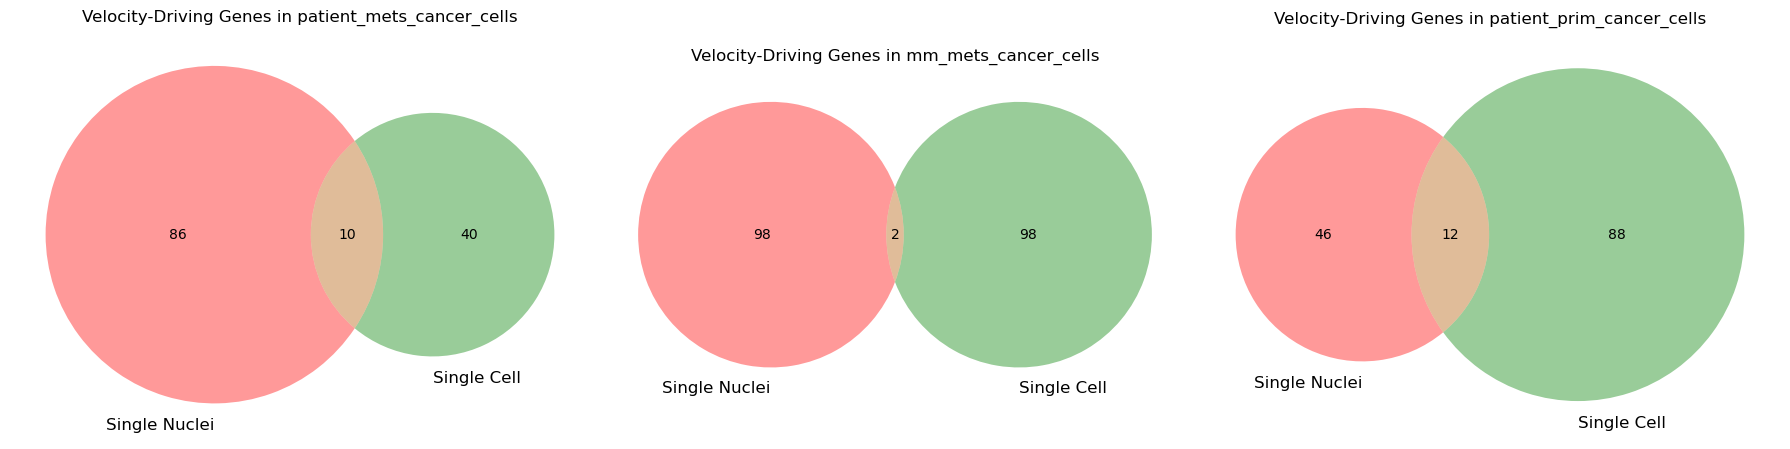

In [175]:
velo_venn("Tumor_Fibrogenic")

### Tumor Interactive

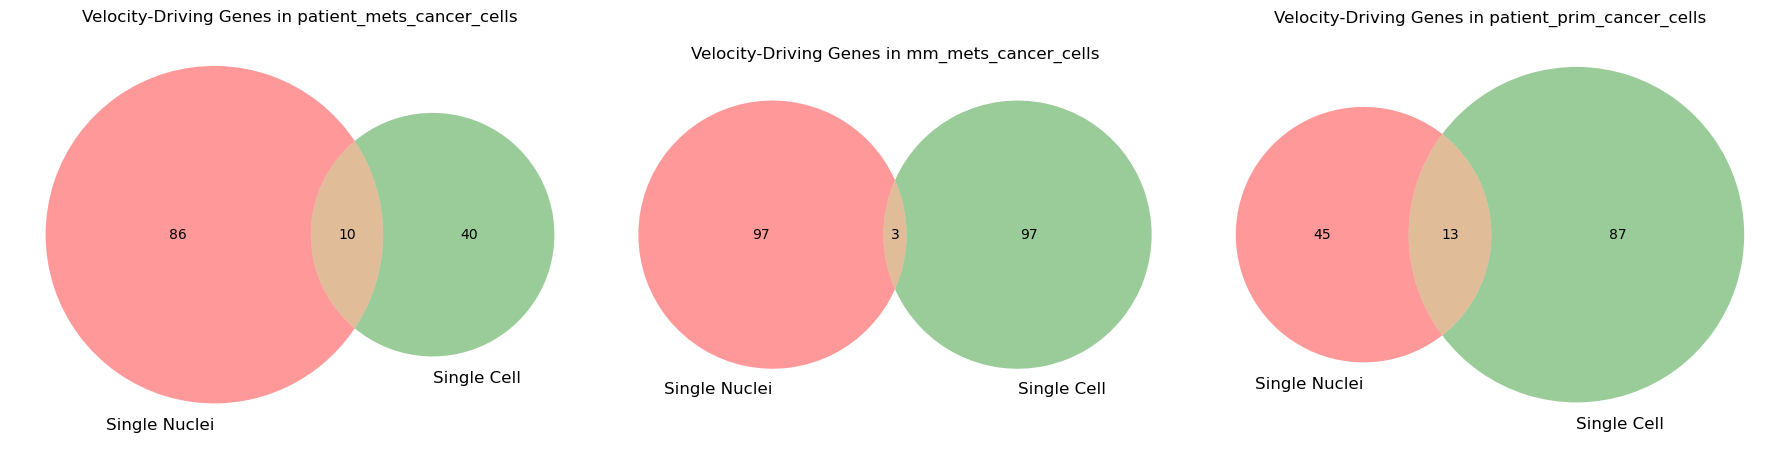

In [176]:
velo_venn("Tumor_Interactive")

### Tumor Progenitor

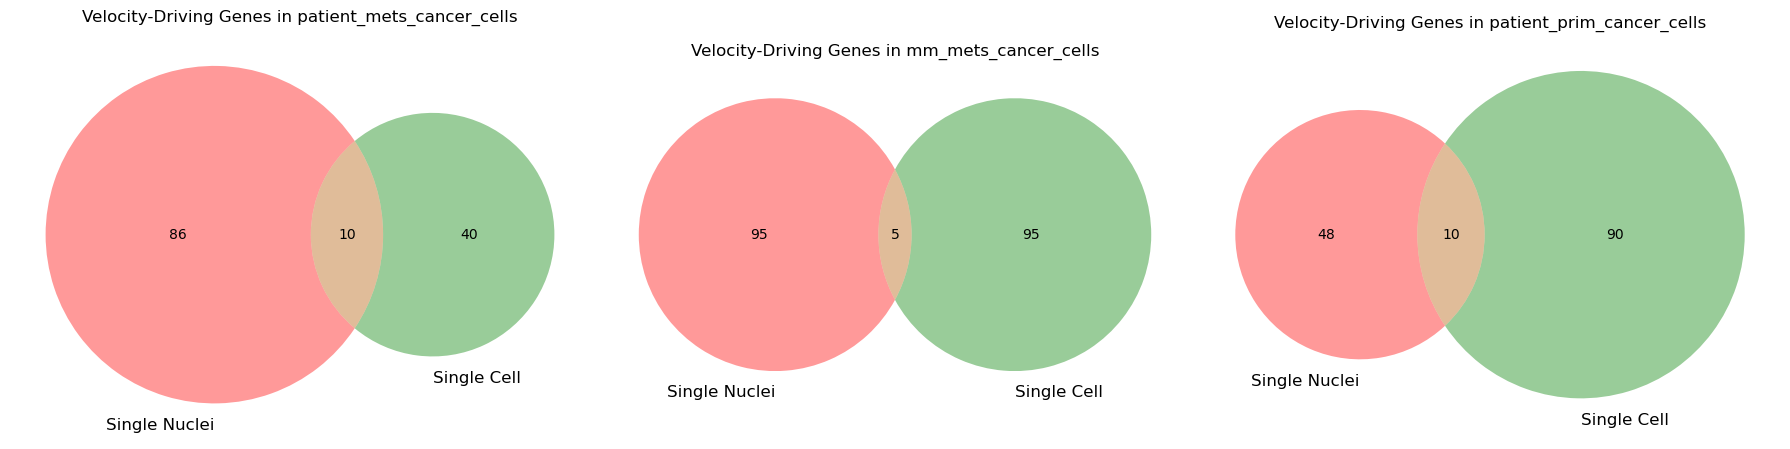

In [177]:
velo_venn("Tumor_Progenitor")

### Tumor Proliferative

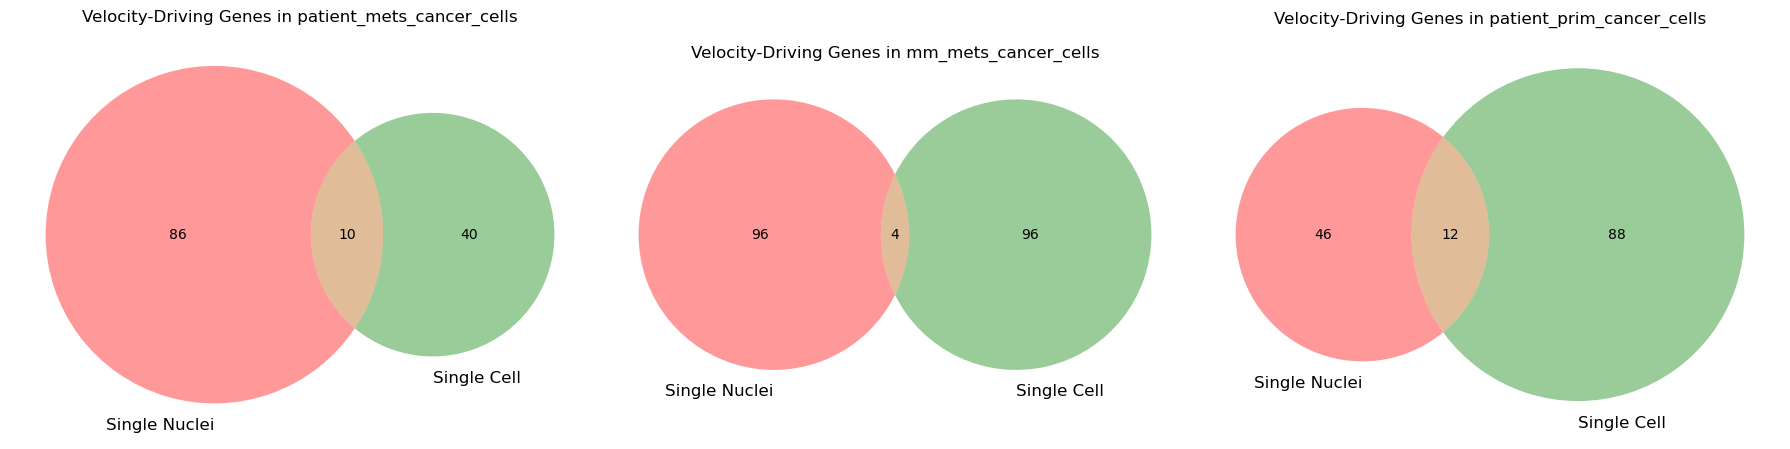

In [178]:
velo_venn("Tumor_Proliferative")

### Tumor Synthetic

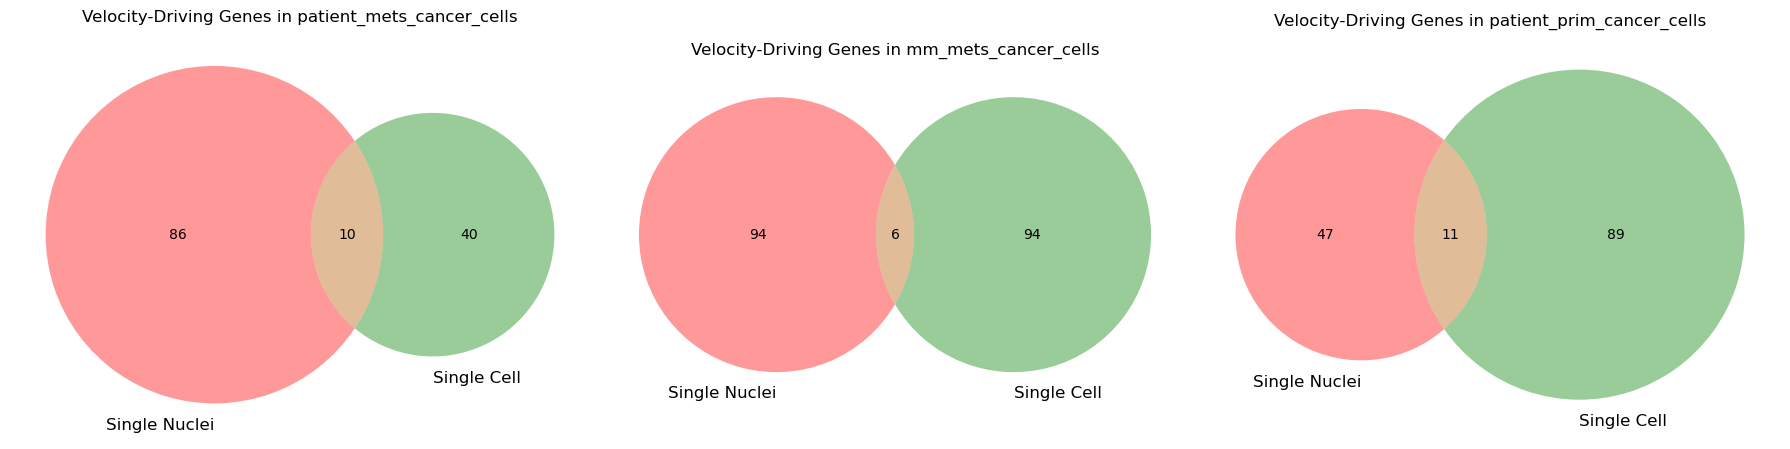

In [179]:
velo_venn("Tumor_Synthetic")

It doesn't seem like there's many shared RNA velocity driver genes between the two technologies. I'm not at all surprised by this.

## Examine Velocity In Shared Genes

For a subset of the genes that are shared between the two sequencing methods, I'm going to look at the velocity values for each technology in the same umap space.

I'll look at this in patient primary cancer cells, as these samples shared the most velocity-driving genes across all cell types.

In [245]:
sc_patient_prim = sc_ob_dict["patient_prim_cancer_cells"]
sn_patient_prim = sn_ob_dict["patient_prim_cancer_cells"]

# get shared top velocity genes
sc_pp_genes = set(sc_velo_genes["patient_prim_cancer_cells"].values.flatten().tolist())
sn_pp_genes = set(sn_velo_genes["patient_prim_cancer_cells"].values.flatten().tolist())

shared_pp_genes = list(sc_pp_genes & sn_pp_genes)

# also get top genes for each cell type in each technology
top_sc = sc_velo_genes["patient_prim_cancer_cells"].iloc[0, ]
top_sn = sn_velo_genes["patient_prim_cancer_cells"].iloc[0, ]
top_sc

Tumor_Apoptosis        NDRG1
Tumor_Fibrogenic         FN1
Tumor_Interactive      HMOX1
Tumor_Progenitor       PTH1R
Tumor_Proliferative      GRP
Tumor_Synthetic        PANX3
Name: 0, dtype: object

We have 13 genes across all tumor subtyes that have cluster-specific differential velocity expression in both the single-cell and single-nuclei patient primary data.


In [ ]:
scv.pl.velocity(sc_patient_prim, shared_pp_genes[:5], color = "Ann_Level3", ncols = 2)
scv.pl.velocity(sn_patient_prim, shared_pp_genes[:5], color = "Ann_Level3", ncols = 2)

# Compare Confidence and Magnitude of Velocity Across Data types

We can get estimates of the speed of the velocity -- the length of the velocity vectors -- and the coherence of the velocity -- how much do the velocity vectors "agree" with each other within a certain cell type.

In [19]:
sc_keys = list(sc_ob_dict.keys())
keys = "velocity_length", "velocity_confidence"
for ob in sc_keys:
    tmp = sc_ob_dict[ob]
    scv.tl.velocity_confidence(tmp)
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    sc_ob_dict[ob] = tmp



--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01

In [20]:
tmp = sc_ob_dict["patient_prim_cancer_cells"]
scv.tl.velocity_confidence(tmp)


keys = 'velocity_length', 'velocity_confidence'

df = tmp.obs.groupby("Ann_Level3")[keys]

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [270]:
for ob in ob_names:
    tmp = ob_list[ob]
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    ob_list[ob] = tmp

tmp.obs.groupby("Ann_Level3")["velocity_confidence"]

NameError: name 'ob_names' is not defined

In [ ]:
scv.pl.scatter(ob_list["mm_prim_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["mm_mets_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["dogs_prim_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

We're now going to investigate the trajectories of the rna velocity estimates, and get a more empirical figure of how the cells are differentiating according to the velocity estimates.

In [32]:
keys = ['velocity_length', 'velocity_confidence']
for ob in ob_names:
    tmp = ob_list[ob]
    df = tmp.obs.groupby('Ann_Level3')[keys].mean().T
    df.style.background_gradient(cmap='coolwarm', axis=1)



In [27]:
df = scv.get_df(tmp, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0.23,0,0
2,0,0.09,0,0,0.045,0
3,0.15,0,0,0,0,0.16
4,0,0,0,0,0,0
5,0,0,0,0,0,0


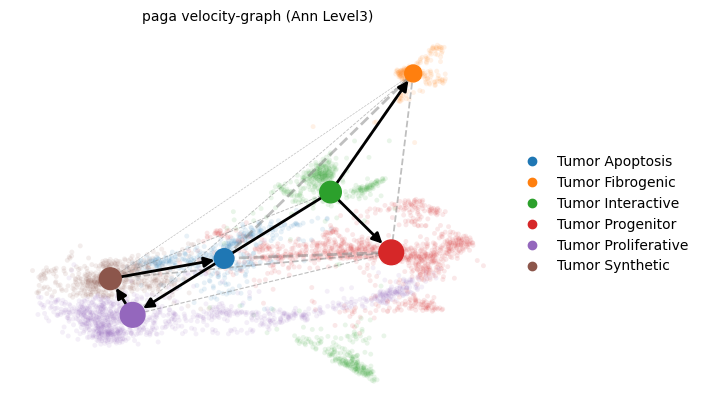

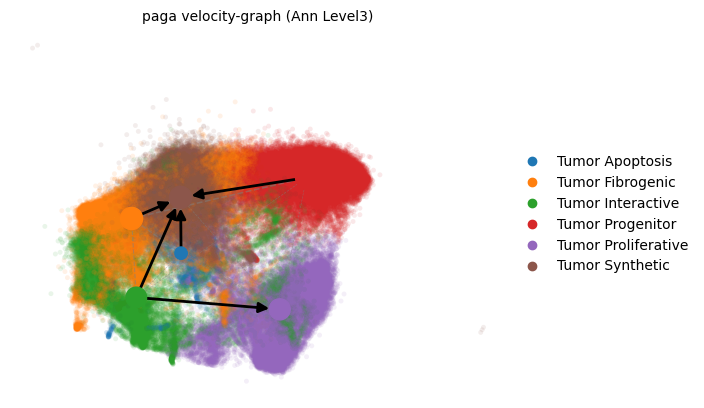

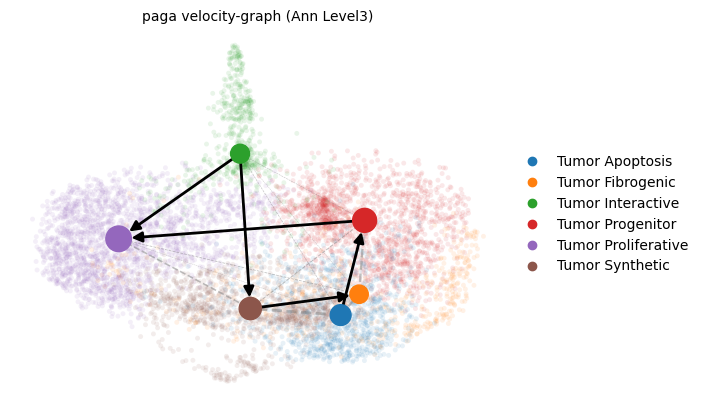

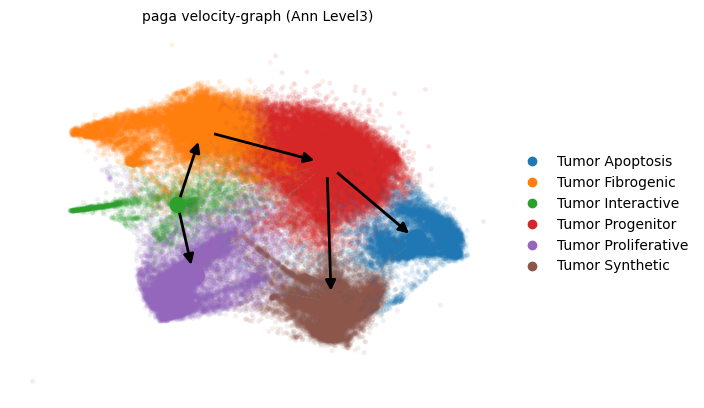

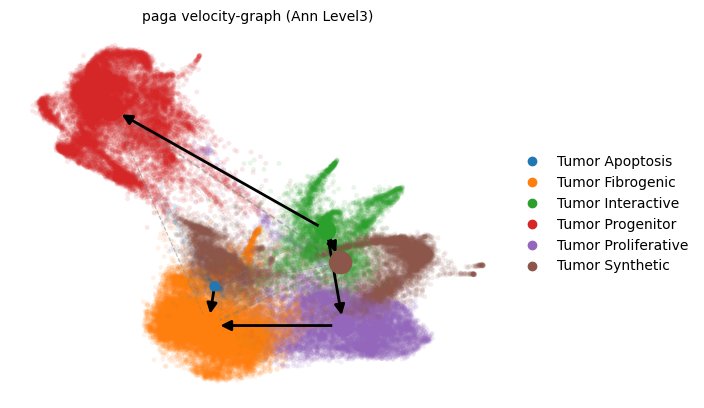

In [29]:
for ob in ob_names:
    tmp = ob_list[ob]
    scv.pl.paga(tmp, basis='fdl', size=50, alpha=.1,
                min_edge_width=2, node_size_scale=1.5)